# Customer Segmentation Using k-Means
* We want to look at data on closed deals and determine if we can group the customer base based on similar characteristics (size of customer, historical purchases, recency of purchase, deal size, geography, etc.)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('C:/Users/segmentation_data.csv')
data.head(n=5)

,OpportunityId,Theater,Segment,Direct,MQL,Employee,AnnualRevenue,SoftwareAmount,Push,NewOrExisting,Tickets_6Mo,TotalClosedLostAmount_24Mo,TotalClosedWonAmount_24Mo,TotalClosedWonAmount_6Mo,TotalClosedLostAmount_6Mo,WinRate_24Mo
0,450929,EMEA,SMB,N,Channel,40,0.0,3528.24,1,Existing,0,4237,80354,15211,0,0.92
1,95384,EMEA,SMB,N,Channel,40,0.0,3699.54,2,Existing,0,4237,81598,14785,0,0.92
2,344340,EMEA,SMB,N,Channel,40,0.0,3573.99,1,Existing,0,2118,83035,18164,0,0.96
3,359139,EMEA,SMB,N,Channel,40,0.0,3214.36,1,Existing,0,0,86609,18016,0,1.00
4,73204,EMEA,SMB,N,Channel,40,0.0,3400.15,1,Existing,0,0,84460,17591,0,1.00


In [3]:
data.dtypes

OpportunityId                   int64
Theater                        object
Segment                        object
Direct                         object
MQL                            object
Employee                        int64
AnnualRevenue                 float64
SoftwareAmount                float64
Push                            int64
NewOrExisting                  object
Tickets_6Mo                     int64
TotalClosedLostAmount_24Mo      int64
TotalClosedWonAmount_24Mo       int64
TotalClosedWonAmount_6Mo        int64
TotalClosedLostAmount_6Mo       int64
WinRate_24Mo                  float64
dtype: object

In [4]:
data.isnull().sum().sort_values()

OpportunityId                 0
Theater                       0
Segment                       0
Direct                        0
MQL                           0
Employee                      0
AnnualRevenue                 0
SoftwareAmount                0
Push                          0
NewOrExisting                 0
Tickets_6Mo                   0
TotalClosedLostAmount_24Mo    0
TotalClosedWonAmount_24Mo     0
TotalClosedWonAmount_6Mo      0
TotalClosedLostAmount_6Mo     0
WinRate_24Mo                  0
dtype: int64

<Figure size 432x288 with 0 Axes>

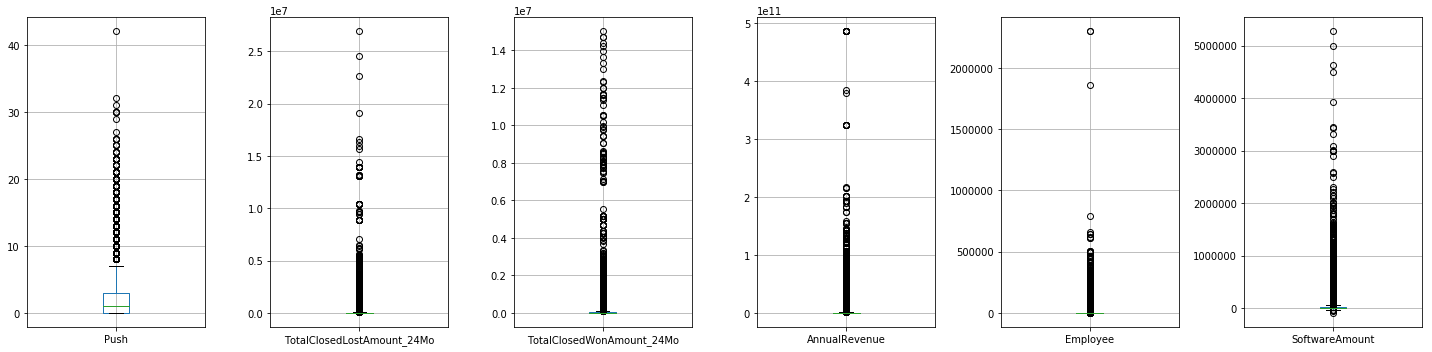

In [8]:
plt.clf()
df_num_cols =  ['Push' , 'TotalClosedLostAmount_24Mo', 'TotalClosedWonAmount_24Mo', 'AnnualRevenue', 'Employee', 'SoftwareAmount']
fig, axes = plt.subplots(1, len(df_num_cols), sharey=False, figsize=(20,5))
for i, col in enumerate(df_num_cols):
  a = data.boxplot(col, ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

In [10]:
data.describe().round()

,OpportunityId,Employee,AnnualRevenue,SoftwareAmount,Push,Tickets_6Mo,TotalClosedLostAmount_24Mo,TotalClosedWonAmount_24Mo,TotalClosedWonAmount_6Mo,TotalClosedLostAmount_6Mo,WinRate_24Mo
count,89059.0,89059.0,8.905900e+04,89059.0,89059.0,89059.0,89059.0,89059.0,89059.0,89059.0,89059.0
mean,250288.0,3855.0,1.602171e+09,31120.0,2.0,7.0,61131.0,73950.0,18440.0,18548.0,0.0
std,144587.0,24897.0,1.051139e+10,97459.0,3.0,21.0,394454.0,357902.0,109840.0,141597.0,0.0
min,12.0,0.0,-6.741528e+07,-88824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,125116.0,0.0,0.000000e+00,1762.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,250410.0,100.0,1.390000e+07,8632.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,376403.0,993.0,2.440000e+08,26000.0,3.0,5.0,17489.0,28812.0,0.0,0.0,1.0
max,499989.0,2300000.0,4.856510e+11,5268208.0,42.0,706.0,26887935.0,15009404.0,5035143.0,10176460.0,1.0


In [12]:
#impute employee and annual revenue using segment
data.Employee.groupby(data.Segment).median().round()

Segment
Enterprise          1346.0
Large Enterprise     390.0
Mid-Market           226.0
No Segment             0.0
SMB                   15.0
Name: Employee, dtype: float64

In [13]:
data.AnnualRevenue.groupby(data.Segment).median().round()

Segment
Enterprise          157368000.0
Large Enterprise    141826499.0
Mid-Market           30000000.0
No Segment                  0.0
SMB                   1099220.0
Name: AnnualRevenue, dtype: float64

In [19]:
data['Employee_imp'] = np.where((data['Employee'] == 0) & (data['Segment'] == 'SMB'), 20,
                                np.where((data['Employee'] == 0) & (data['Segment'] == 'Mid-Market'), 250,
                                         np.where((data['Employee'] == 0) & (data['Segment'] == 'Large Enterprise'), 500,
                                                  np.where((data['Employee'] == 0) & (data['Segment'] == 'Enterprise'), 1400,
                                                           np.where((data['Employee'] == 0) & (data['Segment'] == 'No Segment'), 140, data['Employee'])))))
data['Theater'] = np.where((data['Theater'] == 'GSI') | (data['Theater'] == 'No Reporting Level'), 'Americas', data['Theater'])
data['HasClosedWon_6Mo'] = np.where(data['TotalClosedWonAmount_6Mo'] > 0, 1, 0)
data['HasTickets_6Mo'] = np.where(data['Tickets_6Mo'] > 0, 1, 0)
data['DealSize_new'] = np.where(data['SoftwareAmount'] < 50000, 'Under$50K', 'Over$50K')

In [20]:
cat = ['NewOrExisting', 'Theater', 'MQL', 'HasClosedWon_6Mo', 'HasTickets_6Mo', 'Direct', 'DealSize_new']
for col in data.columns:
  if col in cat:
    print(" ")
    print("---- %s ---" % col)
    print(data[col].value_counts(normalize=True))
    print()
  else:
    pass

 
---- Theater ---
Americas    0.417049
EMEA        0.369295
APAC        0.213656
Name: Theater, dtype: float64

 
---- Direct ---
N    0.838006
Y    0.161994
Name: Direct, dtype: float64

 
---- MQL ---
Sales Rep    0.460414
Channel      0.419014
Marketing    0.120561
Other        0.000011
Name: MQL, dtype: float64

 
---- NewOrExisting ---
Existing    0.567568
New         0.432432
Name: NewOrExisting, dtype: float64

 
---- HasClosedWon_6Mo ---
0    0.789802
1    0.210198
Name: HasClosedWon_6Mo, dtype: float64

 
---- DealSize_new ---
Under$50K    0.850908
Over$50K     0.149092
Name: DealSize_new, dtype: float64

 
---- HasTickets_6Mo ---
0    0.592304
1    0.407696
Name: HasTickets_6Mo, dtype: float64



In [21]:
selectedcols = ['HasClosedWon_6Mo', 'HasTickets_6Mo', 'WinRate_24Mo', 'Theater', 'MQL', 'Employee_imp', 'Push', 'Direct', 'DealSize_new']
selected_data = data[selectedcols]

In [22]:
selected_data.head(n=3)

,HasClosedWon_6Mo,HasTickets_6Mo,WinRate_24Mo,Theater,MQL,Employee_imp,Push,Direct,DealSize_new
0,1,0,0.92,EMEA,Channel,40,1,N,Under$50K
1,1,0,0.92,EMEA,Channel,40,2,N,Under$50K
2,1,0,0.96,EMEA,Channel,40,1,N,Under$50K


In [23]:
selected_data = pd.get_dummies(selected_data, columns = ['Theater', 'MQL', 'DealSize_new', 'Direct'])
selected_data.shape

(89059, 16)

In [26]:
#scale the data so the variance across the different variables are equal
mms = MinMaxScaler()
mms.fit(selected_data)
data_tr = mms.transform(selected_data)

In [27]:
#PCA
pca_mod = PCA()
pca_mod.fit_transform(data_tr)

array([[ 2.64678468e-01, -5.49988667e-01,  9.56196515e-01, ...,
         2.40636179e-13,  1.18363221e-15,  4.88003644e-16],
       [ 2.64973328e-01, -5.50018532e-01,  9.55545256e-01, ...,
         5.54794578e-14,  2.53708880e-16,  1.68967861e-17],
       [ 2.55710150e-01, -5.43924439e-01,  9.74561589e-01, ...,
         2.12127812e-13, -7.64063421e-16, -3.15743505e-16],
       ...,
       [ 6.57363688e-01, -8.51892648e-01,  1.43477011e-01, ...,
        -3.71795410e-17, -9.34376719e-18, -2.73096259e-17],
       [-9.61578642e-01, -3.90706836e-01,  6.61239846e-01, ...,
        -2.36689154e-17, -1.55015101e-17, -2.92947145e-17],
       [-8.49769537e-01, -4.66479821e-01,  4.32327688e-01, ...,
         1.02754132e-16, -2.69678721e-17, -2.47680967e-17]])

<Figure size 432x288 with 0 Axes>

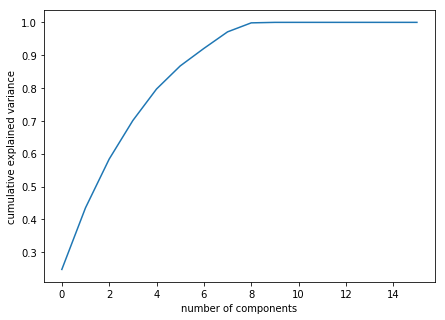

In [28]:
plt.clf()
plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca_mod.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [29]:
pc = PCA(n_components=5)
reduced_data = pc.fit_transform(data_tr)

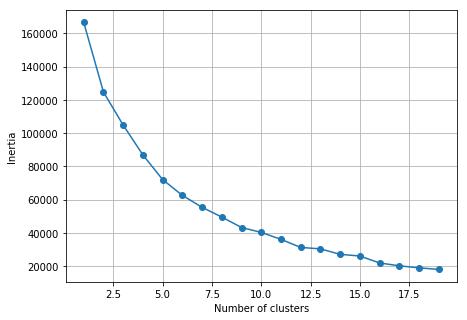

In [30]:
# The elbow method : the sum of squares at each number of clusters is calculated and graphed, and the user looks for a change of slope from steep to shallow (an elbow) to determine the optimal number of clusters
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_) #within cluster sum of squares

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(7,5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [31]:
#Cluster the data
kmeans = KMeans(n_clusters=7, random_state=0).fit(reduced_data)

#Glue back to original data
data['clusters'] = kmeans.labels_
data.clusters.value_counts(normalize=True)

2    0.195545
4    0.171336
0    0.156671
1    0.147902
5    0.146510
6    0.109242
3    0.072794
Name: clusters, dtype: float64

In [32]:
data.groupby(data.clusters).mean().round(2)

,OpportunityId,Employee,AnnualRevenue,SoftwareAmount,Push,Tickets_6Mo,TotalClosedLostAmount_24Mo,TotalClosedWonAmount_24Mo,TotalClosedWonAmount_6Mo,TotalClosedLostAmount_6Mo,WinRate_24Mo,Employee_imp,HasClosedWon_6Mo,HasTickets_6Mo,clusters
clusters,,,,,,,,,,,,,,,
0,251181.58,3649.73,1.673455e+09,9567.48,1.82,14.53,93727.20,128079.31,30566.20,28909.41,0.41,3745.75,0.30,0.70,0.0
1,249035.58,2019.20,8.637249e+08,22546.42,2.56,1.78,15714.98,34534.37,9668.68,4652.64,0.27,2110.74,0.16,0.22,1.0
2,250778.44,2232.32,1.075858e+09,8069.36,1.68,3.91,26032.22,55621.39,13298.03,8080.43,0.41,2333.72,0.23,0.37,2.0
3,249743.42,8010.30,3.291697e+09,13875.28,1.25,18.96,125884.55,162376.12,49324.12,39265.76,0.76,8154.26,0.61,0.85,3.0
4,249935.12,2679.90,9.198147e+08,24742.72,2.34,7.40,54707.59,51209.17,13451.67,16856.00,0.28,2771.59,0.19,0.44,4.0
5,249494.97,3428.65,8.372378e+08,13733.95,2.54,0.26,10270.90,1170.69,49.55,3550.96,0.04,3543.58,0.00,0.04,5.0
6,251806.89,9187.11,4.412084e+09,159706.68,3.68,12.03,173831.87,156844.81,34037.77,50203.93,0.26,9317.35,0.17,0.45,6.0


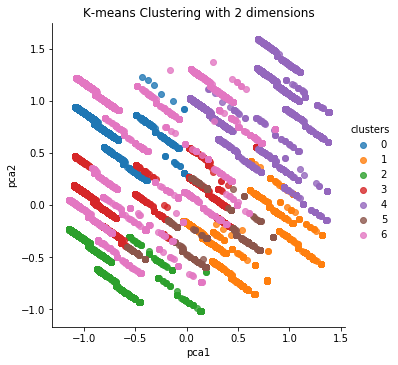

None

In [33]:
#visualize results in 2D
twod_pca = PCA(n_components=2).fit_transform(data_tr)
results_2d_pca = pd.DataFrame(twod_pca,columns=['pca1','pca2'])
results_2d_pca['clusters'] = kmeans.labels_
sns.lmplot(x= 'pca1', y= 'pca2', hue= 'clusters', data=results_2d_pca, fit_reg=False)
plt.title('K-means Clustering with 2 dimensions')
display(plt.show())

In [34]:
cat = ['Direct', 'NewOrExisting', 'HasTickets_6Mo', 'HasClosedWon_6Mo', 'Segment', 'Theater', 'MQL', 'DealSize_new']
for col in cat:
  print(pd.crosstab(data.clusters, data[col], normalize='index').round(2)*100)
  print()

Direct        N     Y
clusters             
0         100.0   0.0
1          66.0  34.0
2         100.0   0.0
3          99.0   1.0
4          35.0  65.0
5         100.0   0.0
6         100.0   0.0

NewOrExisting  Existing   New
clusters                     
0                  80.0  20.0
1                  42.0  58.0
2                  67.0  33.0
3                  99.0   1.0
4                  54.0  46.0
5                  18.0  82.0
6                  53.0  47.0

HasTickets_6Mo     0     1
clusters                  
0               30.0  70.0
1               78.0  22.0
2               63.0  37.0
3               15.0  85.0
4               56.0  44.0
5               96.0   4.0
6               55.0  45.0

HasClosedWon_6Mo      0     1
clusters                     
0                  70.0  30.0
1                  84.0  16.0
2                  77.0  23.0
3                  39.0  61.0
4                  81.0  19.0
5                 100.0   0.0
6                  83.0  17.0

Segment   Enter

Based on the analysis above, we can segmnent the customer base into seven groups based which are quite distinct. There is a cluster for larger deal sizes (cluster 6) which are most likely low velocity deals. There is a cluster for new customers which have deals sourced by marketing, primarily in APAC (cluster 5). This group has the lowest historical win rate. There is a segment for partner deals in Americas (cluster 0) which are likely to be high velocity deals. Cluster 1 and 2 are EMEA customers - one is primarity partner deals and one is direct deals. Cluster 4 is partner deals in Americas. Cluster 3 is existing customers that have the highest historical win rate.

There is some overlap between the clusters which could be improved with better data treatment or different clustering algorithm.